# **Imports**

# Computer Vison (CV) - openCV

In [1]:
from IPython.display import clear_output
#!pip install tf_explain
clear_output()

In [1]:
# Common
import os 
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add

from keras.preprocessing.image import load_img, img_to_array

# Metrics
from keras.metrics import MeanIoU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM


2024-03-16 13:39:49.007415: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 13:39:49.026062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:39:49.026074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:39:49.026565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:39:49.029956: I tensorflow/core/platform/cpu_feature_guar

ModuleNotFoundError: No module named 'tqdm'

# **Data**

In [3]:
def load_image(image, SIZE):
    image = tf.cast(tfi.resize(img_to_array(load_img(image)), (SIZE, SIZE)), tf.float32)/255.
    return image

def load_images(paths, SIZE, trim=None, channels=3):
  
    if trim is not None:
        paths = paths[:trim]
        images = np.zeros(shape=(len(paths), SIZE, SIZE, channels))

    if channels==3:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img
    elif channels==1:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img[:,:,:1]
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')

In [5]:
def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)

In [6]:
root_path = './COVID-19_Radiography_Dataset/'
# image_path = root_path + 'images/'
# mask_path = root_path + 'masks/'

In [7]:
#reame "Viral Pneumonia" to 'Viral_Pneumonia'
os.system(f"Rename {root_path}'Viral Pneumonia' {root_path}Viral_Pneumonia")

1

In [8]:
glob(root_path)

['./COVID-19_Radiography_Dataset/']

In [9]:
glob('./COVID-19_Radiography_Dataset/*/*/')

['./COVID-19_Radiography_Dataset\\COVID\\images\\',
 './COVID-19_Radiography_Dataset\\COVID\\masks\\',
 './COVID-19_Radiography_Dataset\\Lung_Opacity\\images\\',
 './COVID-19_Radiography_Dataset\\Lung_Opacity\\masks\\',
 './COVID-19_Radiography_Dataset\\Normal\\images\\',
 './COVID-19_Radiography_Dataset\\Normal\\masks\\',
 './COVID-19_Radiography_Dataset\\Viral Pneumonia\\images\\',
 './COVID-19_Radiography_Dataset\\Viral Pneumonia\\masks\\']

In [10]:
l1 = os.listdir(root_path)
print(l1)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [11]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [8]:
#move xlsx adn txt files to parent folder 
for i in l1:
    if (".xlsx" in i) | (".txt" in i):
        os.system(f"mv ./{root_path}/'{i}' ./")

In [12]:
from PIL import Image

# create labels from image folder

In [15]:
labels = []
image_paths = []
mask_paths = []

for i in class_names:
    #print(i)
    l2 = os.listdir(root_path+i)
    
    for j in l2:
        #print("i is", i)
        l3 = os.listdir(root_path+i+'/'+j)
        for k in l3:
            if (j=='images') and (".ipynb_checkpoints" != k):
                # img = Image.open(root_path+i+'/'+j+'/'+k)
                image_paths.append(root_path+i+'/'+j+'/'+k) 
                labels.append(i)
            elif (j=='masks') and (".ipynb_checkpoints" != k):
                mask_paths.append(root_path+i+'/'+j+'/'+k) 
            #    del img
            #./COVID-19_Radiography_Dataset/COVID/images/COVID-1.png
            #img = Image.open(impath+i+'/'+j).convert('RGB')
            #img = img.resize(size=(50,50))
            #imgs.append(np.array(img))

In [16]:
len(mask_paths)

21165

In [17]:
len(image_paths)

21165

In [18]:
images = load_images(image_paths, SIZE=256, trim=200)
masks = load_images(mask_paths, SIZE=256, trim=200, channels=1)

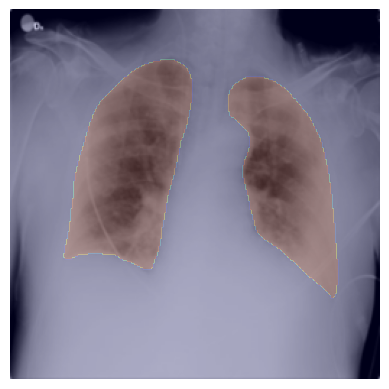

In [26]:
show_mask(images[0], masks[0], alpha=0.2)

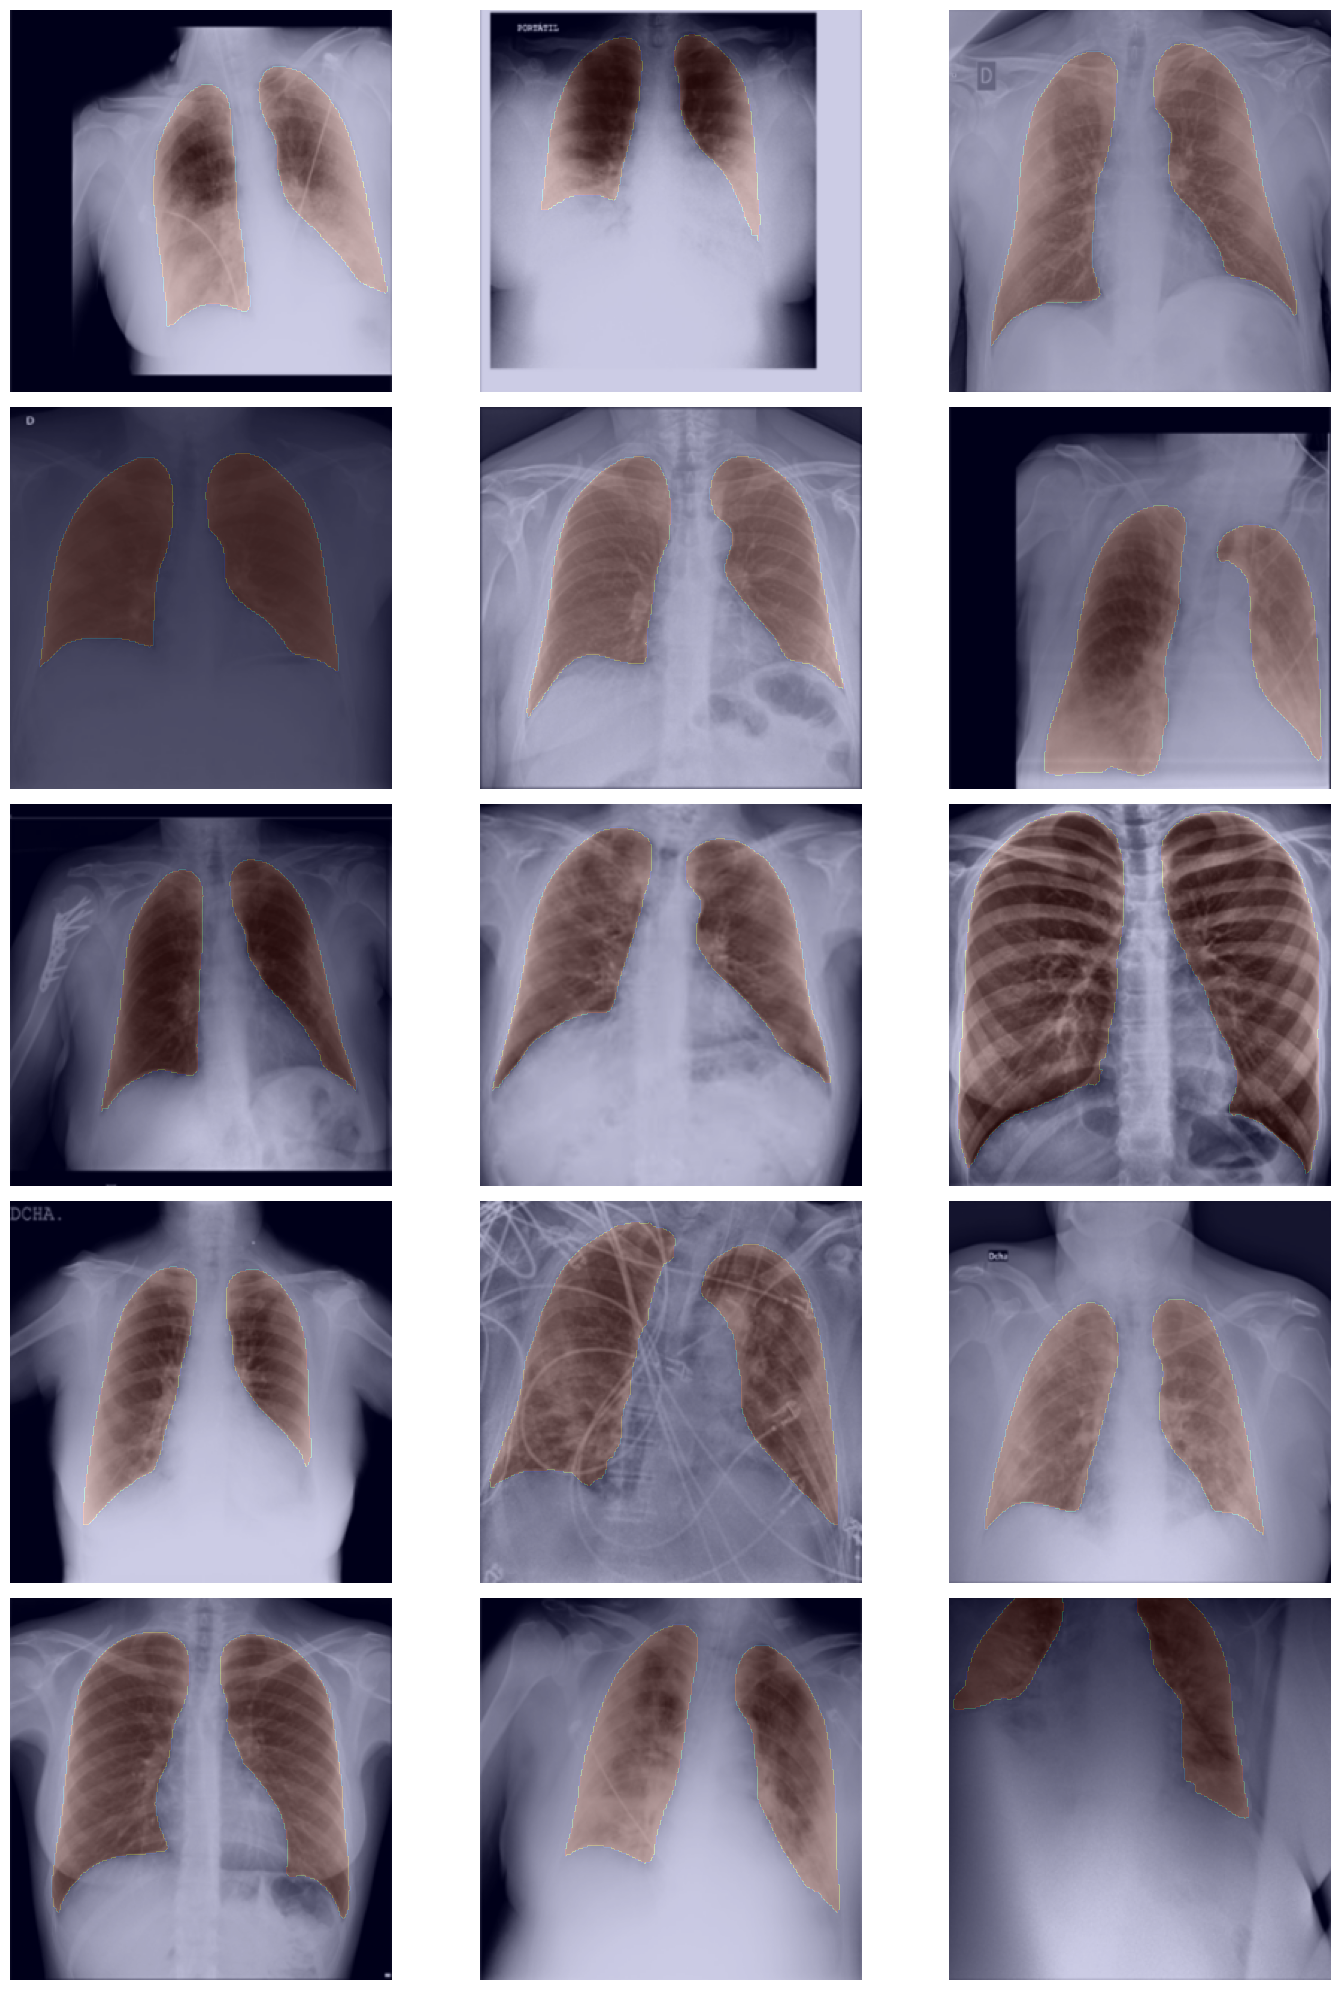

In [27]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

# **Splitting Image Data**

In [22]:
SIZE = 256
images, masks = load_images(image_paths, SIZE, trim=2000), load_images(mask_paths, SIZE, trim=2000, channels=1)

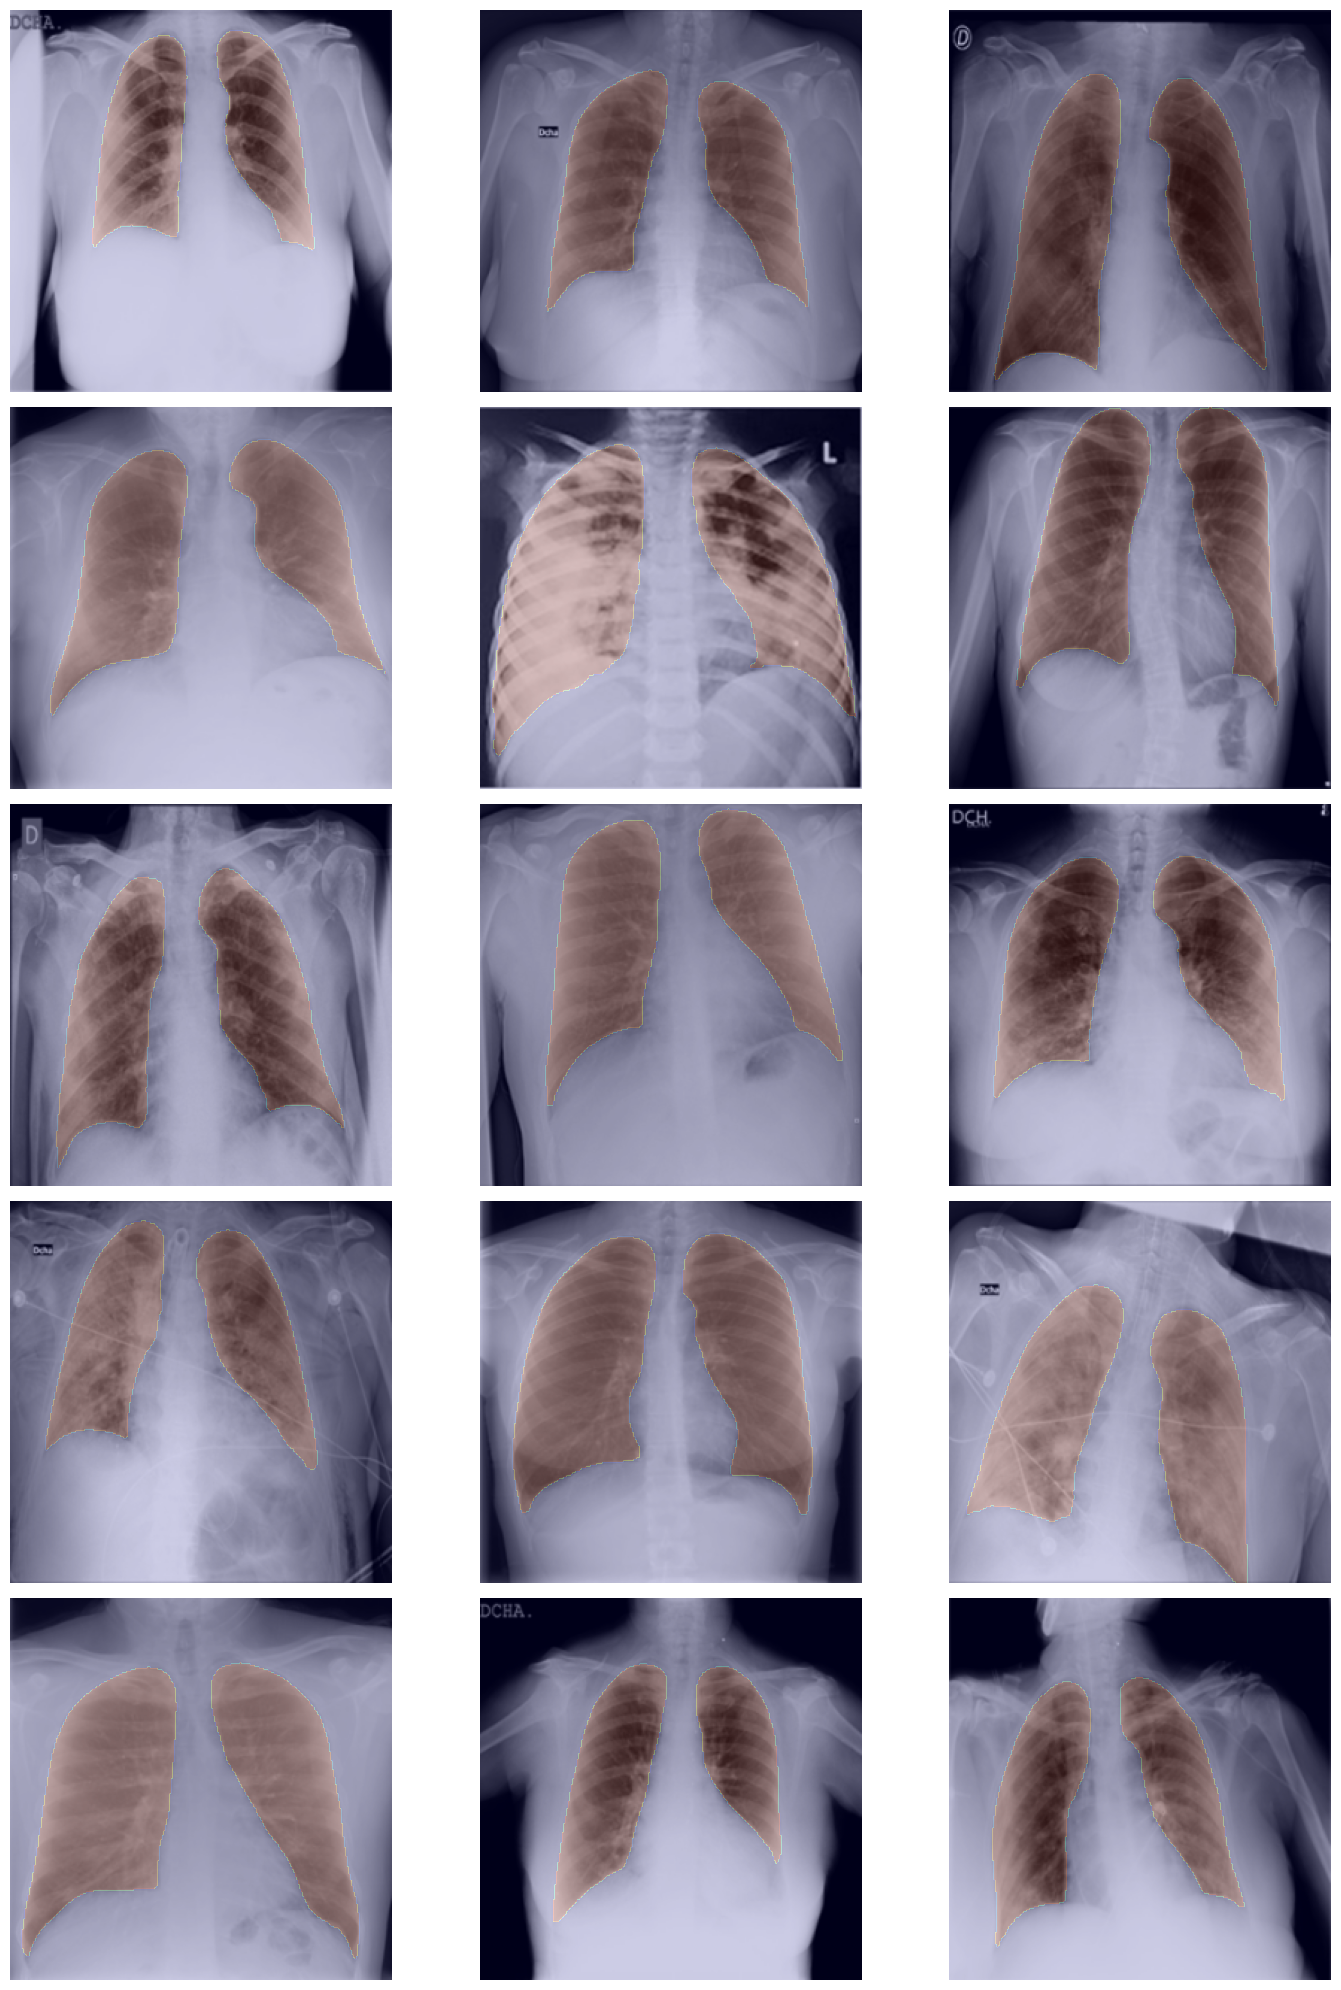

In [28]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

# **Model**

In [30]:
BATCH_SIZE = 32
SPE = len(images)//BATCH_SIZE

In [31]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    

    if dropout_prob > 0:         
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D()(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [32]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [33]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [34]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
                  #,n_filters=32, n_classes=1)

In [35]:
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',MeanIoU(2)])

In [36]:
#fit self-define unet model 
unet.fit(
    images, masks,
    validation_split=0.1,
    epochs=10, # This is more than sufficient
    steps_per_epoch=SPE
)

Epoch 1/10


62/62 [==============================] - 186s 3s/step - loss: 0.6982 - accuracy: 0.7342 - mean_io_u: 0.3765 - val_loss: 0.4004 - val_accuracy: 0.7750 - val_mean_io_u: 0.3875
Epoch 2/10
62/62 [==============================] - 181s 3s/step - loss: 0.3200 - accuracy: 0.8558 - mean_io_u: 0.3763 - val_loss: 0.1627 - val_accuracy: 0.9390 - val_mean_io_u: 0.3875
Epoch 3/10
62/62 [==============================] - 181s 3s/step - loss: 0.1631 - accuracy: 0.9378 - mean_io_u: 0.3780 - val_loss: 0.0991 - val_accuracy: 0.9611 - val_mean_io_u: 0.3875
Epoch 4/10
62/62 [==============================] - 181s 3s/step - loss: 0.1270 - accuracy: 0.9517 - mean_io_u: 0.3789 - val_loss: 0.0791 - val_accuracy: 0.9676 - val_mean_io_u: 0.3875
Epoch 5/10
62/62 [==============================] - 182s 3s/step - loss: 0.0961 - accuracy: 0.9630 - mean_io_u: 0.3813 - val_loss: 0.0592 - val_accuracy: 0.9766 - val_mean_io_u: 0.3915
Epoch 6/10
62/62 [==============================] - 184s 3s/step - loss: 

# **Evaluation**

1/1 [==============================] - 0s 45ms/step


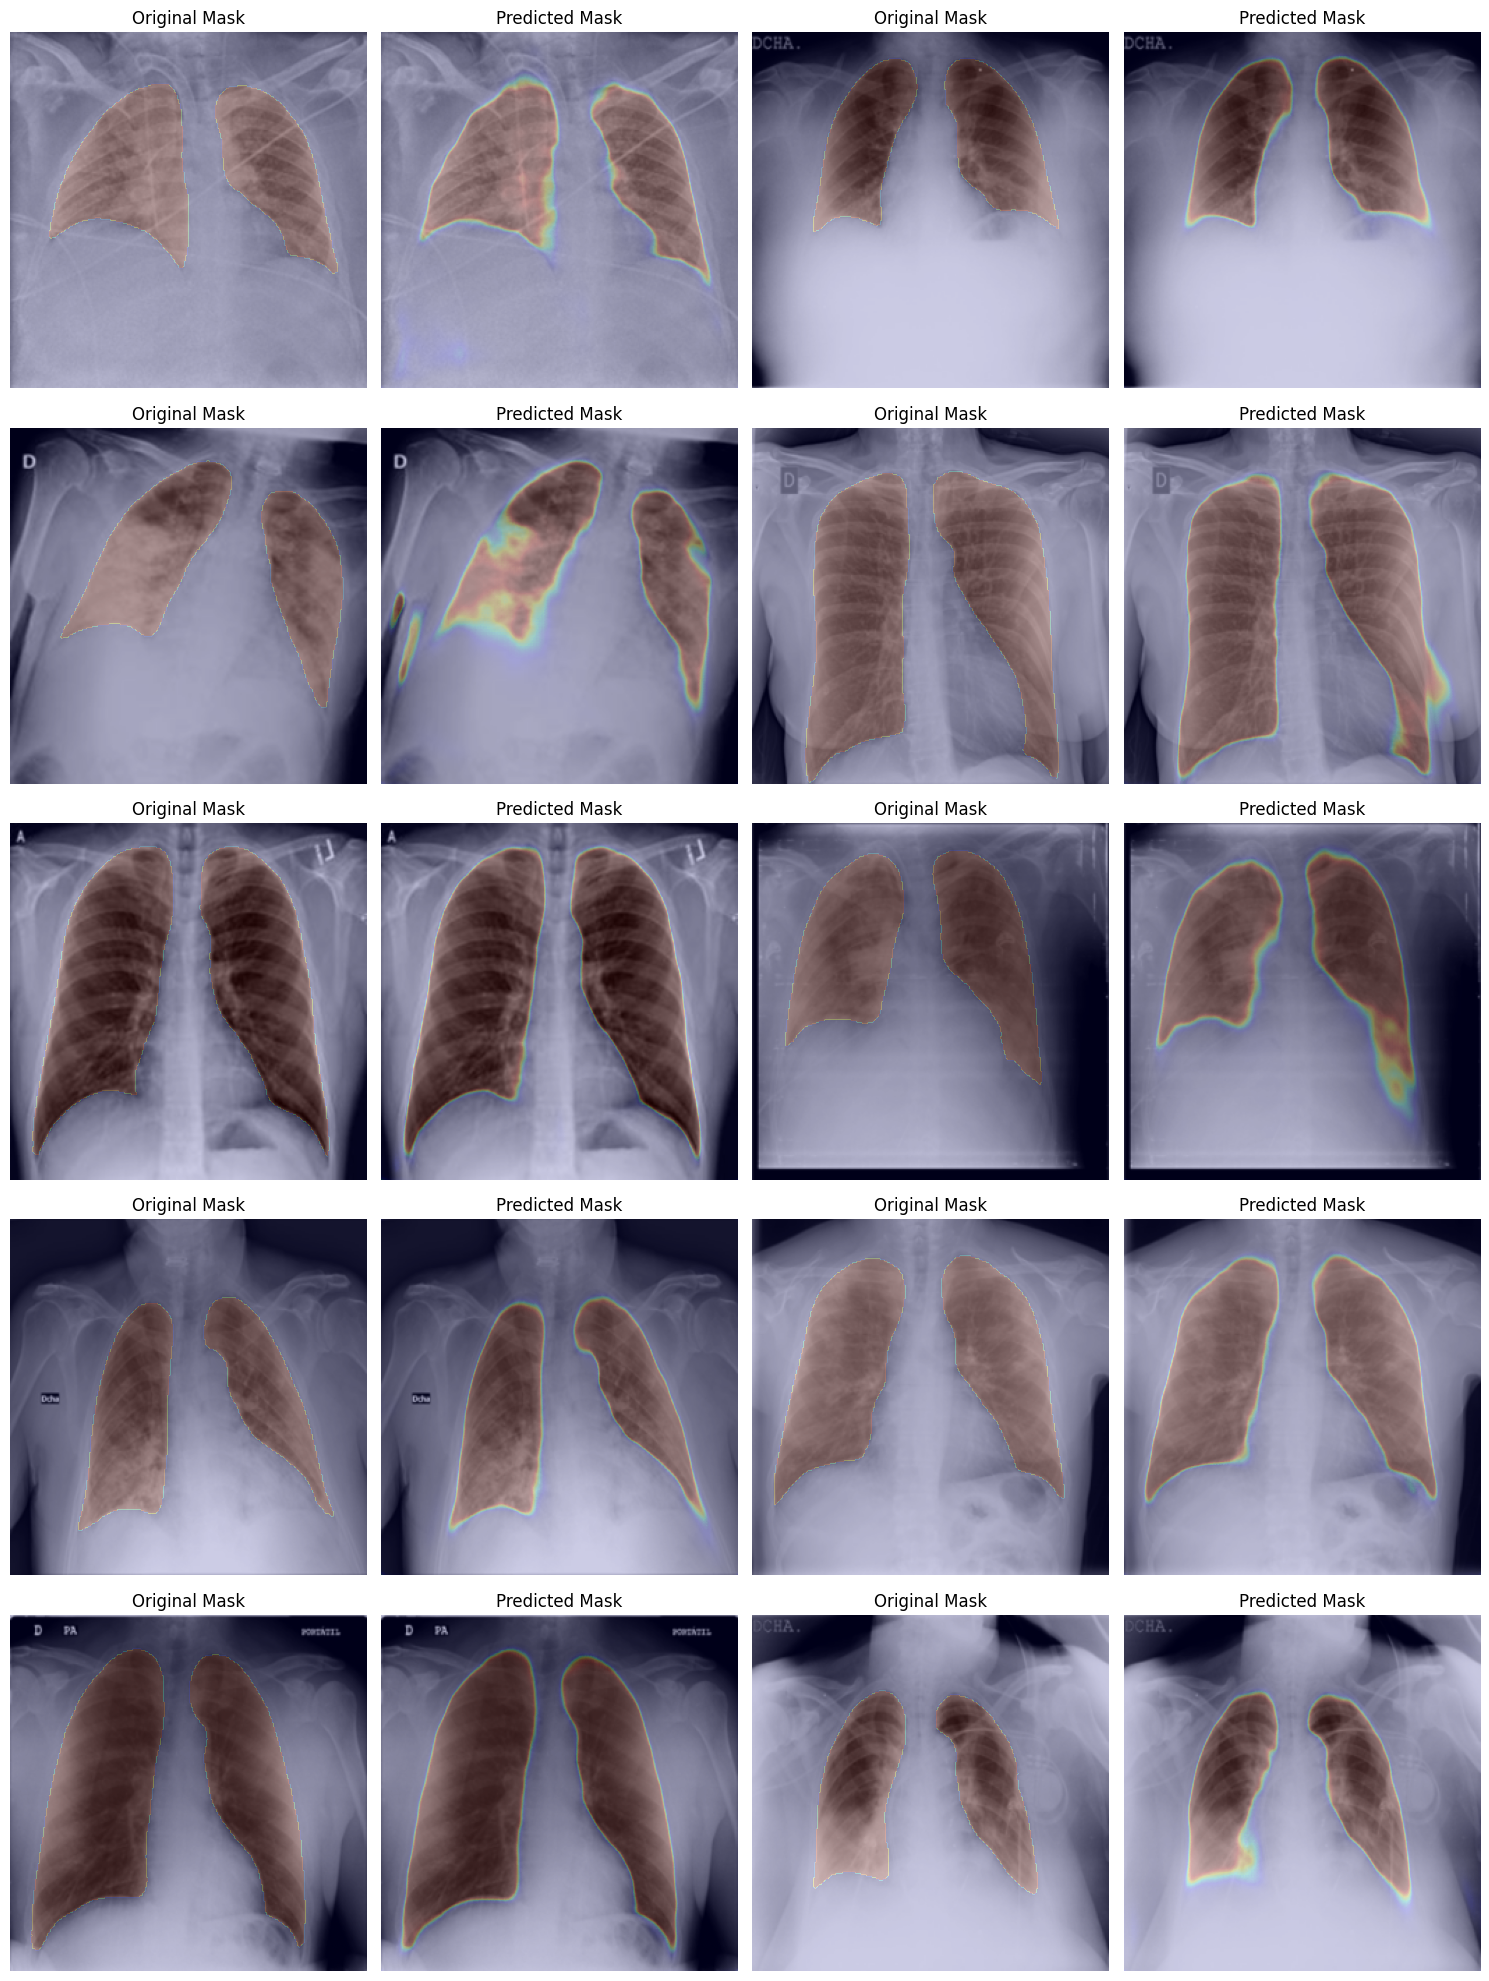

In [47]:
plt.figure(figsize=(15,20))
n = 0
for i in range(1,21):
    plt.subplot(5,4,i)

    if n==0:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        pred_mask = unet.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==3:
        pred_mask = unet.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()